In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#loeme andmed sisse
data_orig=pd.read_csv("soidukid.csv",on_bad_lines='skip', sep=";")

C:\Users\cardo\AppData\Local\Temp\ipykernel_13000\1789013292.py:2: DtypeWarning: Columns (8,9,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data_orig=pd.read_csv("soidukid.csv",on_bad_lines='skip', sep=";")


In [3]:
#kopeerime originaalse andmestiku
data=data_orig.copy()
data.head()

,Andmed seisuga,YLDINE_STAATUS,EESTIS_ESMAREG_KP,ESMANE_REG_KP,KAIGUKASTI_TYYP,Kütuse tüüp,MOOTORI_TYYP,MOOTORI_MAHT,MOOTORI_VOIMSUS,HYBRIIDI_TYYP,...,REG_MASS,TAISMASS,TYHIMASS,TELGI_KOKKU,HEITMENORM,VARV,ISTEKOHTI,Kere nimetus,VK/OM MAAKOND,ARV
0,03.11.2022,PEATATUD,01.01.0987,01.01.1987,NaN,BENSIIN,BENSIIN,1452.0,55.0,NaN,...,1510,1510.0,1050.0,2.0,NaN,BEEZ,5,UNIVERSAAL,PÕLVA MAAKOND,1
1,03.11.2022,PEATATUD,30.12.1899,01.01.1987,NaN,DIISEL,DIISEL,1608.0,40.0,NaN,...,1350,1350.0,910.0,2.0,NaN,BEEZ,5,LUUKPÄRA,HARJU MAAKOND,1
2,03.11.2022,PEATATUD,01.01.1900,01.01.1939,NaN,BENSIIN,BENSIIN,690.0,15.0,NaN,...,1120,1120.0,750.0,2.0,NaN,MUST,4,KUPEE,HARJU MAAKOND,1
3,03.11.2022,PEATATUD,01.01.1900,01.01.1939,NaN,BENSIIN,BENSIIN,2120.0,58.0,NaN,...,2020,2020.0,1430.0,2.0,NaN,HALL,5,SEDAAN,TARTU MAAKOND,1
4,03.11.2022,PEATATUD,01.01.1900,01.01.1948,MANUAAL,BENSIIN,BENSIIN,2445.0,52.0,NaN,...,1550,1550.0,1050.0,2.0,NaN,ROHELINE,5,LUUKPÄRA,SAARE MAAKOND,1


In [4]:
#kustutame ebavajalikud andmed
data=data[data.YLDINE_STAATUS != "PEATATUD"]
data=data.reset_index()
data=data.drop(["Andmed seisuga","index","VARV","ISTEKOHTI", "Kere nimetus", "ARV","Kategooria","Keretüüp","TELGI_KOKKU","TAISMASS", "TYHIMASS","YLDINE_STAATUS","EESTIS_ESMAREG_KP", "MOOTORI_TYYP", "Kütuse tüüp", "HYBRIIDI_TYYP"], axis=1)

In [5]:
#asendame Nan-informatsioonilahtrid käigukastitüübis
#Nan -> manuaal
data["KAIGUKASTI_TYYP"]=data["KAIGUKASTI_TYYP"].fillna("MANUAAL")

In [6]:
#asendame puuduvad NEDC väärtused võimalusel WLTP omadega, vastasel juhul
#eelistame NEDC

for i in range(len(data["CO2_NEDC"])):
    vana=data["CO2_NEDC"].iloc[i]
    uus=data["CO2_WLTP"].iloc[i]
    if str(vana)=="nan" and str(uus)!="nan":
        data.loc[i,'CO2_NEDC']=int(uus)
data=data.drop(["CO2_WLTP"], axis=1)        

In [7]:
#data.to_csv('soidukid_cleaned.csv',encoding='utf-8-sig',sep=';')

In [8]:
#VAZ-de CO2_NEDC NaN väärtused asendame 210-ga, kuna antud autod omavad sama mootorit
for i in range(len(data["CO2_NEDC"])):
    mark=data["Mark"].iloc[i]
    if str(mark)=="VAZ":
        data.loc[i,'CO2_NEDC']=210

In [9]:
#Vaatame autosid, millel on CO2 NaN-valued
#for i in range(len(data["CO2_NEDC"])):
 #  mark=data["Mark"].iloc[i]
  #  maht=data["MOOTORI_MAHT"].iloc[i]
   # tüüp=data["Kütusekombinatsioon"].iloc[i]
    #if str(NEDC)=="nan" and str(mark)=="BMW":
     #   print(str(data["Mark"].iloc[i])+ " " + str(data["Mudel"].iloc[i]) + " " + str(maht) + " " + str(tüüp))

In [10]:
#Peamised mootorid ning nende CO2_NEDC, et vähendada NaN valuesid CO2 tulbas
motoras_VW={1968.0:146.0, 1896.0:162.0, 2461.0:171.0, 2771.0:255.0, 2967.0:180.0 ,1781.0:190.0, 2792.0:278.0}
motoras_BMW={1596.0:171.6, 1991.0:165.3, 2979.0:169.0, 2993.0:170.0, 2926.0:178.0, 1995.0:153.0, 1796.0:208.0, 1950.0:158.0}

In [11]:
#Asendame NaN-valued võimalusel Volkswageni ja Audi peamiste mootorite CO2 reostustasemed
for i in range(len(data["CO2_NEDC"])):
    mootor=data["MOOTORI_MAHT"].iloc[i]
    NEDC=data["CO2_NEDC"].iloc[i]
    mark=data["Mark"].iloc[i]
    if str(NEDC)=="nan" and float(mootor) in motoras_VW.keys() and (str(mark)=="VOLKSWAGEN" or str(mark)=="AUDI"):
        data.loc[i,'CO2_NEDC']=int(motoras_VW.get(float(mootor)))

In [12]:
#Asendame NaN-valued võimalusel BMW peamiste mootorite CO2 reostustasemed
for i in range(len(data["CO2_NEDC"])):
    mootor=data["MOOTORI_MAHT"].iloc[i]
    NEDC=data["CO2_NEDC"].iloc[i]
    mark=data["Mark"].iloc[i]
    if str(NEDC)=="nan" and float(mootor) in motoras_BMW.keys() and str(mark)=="BMW":
        data.loc[i,'CO2_NEDC']=int(motoras_BMW.get(float(mootor)))

In [13]:
#Asendame NaN-valued elektri-autodel nulliga
for i in range(len(data["CO2_NEDC"])):
    kütus=data["Kütusekombinatsioon"].iloc[i]
    NEDC=data["CO2_NEDC"].iloc[i]
    if str(NEDC)=="nan" and str(kütus)=="ELEKTER":
        data.loc[i,'CO2_NEDC']=0

In [14]:
brändid={}
for i in range(len(data["CO2_NEDC"])):
    NEDC=data["CO2_NEDC"].iloc[i]
    if str(NEDC)=="nan":
        if str(data["Mark"].iloc[i]) in brändid.keys():
            brändid[str(data["Mark"].iloc[i])]= int(brändid.get(str(data["Mark"].iloc[i])))+1
        else:
            brändid[str(data["Mark"].iloc[i])]= 1             
brändid=dict(sorted(brändid.items(), key=lambda item: item[1]))
#print(brändid)

In [15]:
#Asendame vigased maakonna nimed
tundmatud=['L��NE-VIRU MAAKOND', 'P�RNU MAAKOND', 'J�RVA MAAKOND', 'P�LVA MAAKOND', 'V�RU MAAKOND']
asendused=["LÄÄNE-VIRU MAAKOND", "PÄRNU MAAKOND", "JÄRVA MAAKOND", "PÕLVA MAAKOND", "VÕRU MAAKOND"]

for i in range(len(tundmatud)):
    data["VK/OM MAAKOND"]=data["VK/OM MAAKOND"].replace([tundmatud[i]],asendused[i])
    
MAAKONNAD=[]
for i in range(len(data["VK/OM MAAKOND"])):
    maakond=data["VK/OM MAAKOND"].iloc[i]
    if str(maakond) not in MAAKONNAD:
        MAAKONNAD.append(str(maakond))

In [16]:
autod_maakonnas={'HARJU MAAKOND':0, 'PÄRNU MAAKOND':0, 'TARTU MAAKOND':0, 'VALGA MAAKOND':0, 'VÕRU MAAKOND':0, 'HIIU MAAKOND':0, 'PÕLVA MAAKOND':0, 'SAARE MAAKOND':0, 'LÄÄNE-VIRU MAAKOND':0, 'IDA-VIRU MAAKOND':0, 'JÕGEVA MAAKOND':0, 'LÄÄNE MAAKOND':0, 'RAPLA MAAKOND':0, 'VILJANDI MAAKOND':0, 'JÄRVA MAAKOND':0, 'MÄÄRAMATA':0}
passatid_maakonnas={'HARJU MAAKOND':0, 'PÄRNU MAAKOND':0, 'TARTU MAAKOND':0, 'VALGA MAAKOND':0, 'VÕRU MAAKOND':0, 'HIIU MAAKOND':0, 'PÕLVA MAAKOND':0, 'SAARE MAAKOND':0, 'LÄÄNE-VIRU MAAKOND':0, 'IDA-VIRU MAAKOND':0, 'JÕGEVA MAAKOND':0, 'LÄÄNE MAAKOND':0, 'RAPLA MAAKOND':0, 'VILJANDI MAAKOND':0, 'JÄRVA MAAKOND':0, 'MÄÄRAMATA':0}
passatid_kokku=0

for i in range(len(data["VK/OM MAAKOND"])):
    mudel=data["Mudel"].iloc[i]
    maakond=data["VK/OM MAAKOND"].iloc[i]
    autod_maakonnas[str(maakond)]= int(autod_maakonnas.get(str(maakond)))+1
    if "PASSAT" in str(mudel):
        passatid_kokku+=1
        passatid_maakonnas[str(maakond)]= int(passatid_maakonnas.get(str(maakond)))+1

print("Passateid Eestis " + str(passatid_kokku))
print(autod_maakonnas)
print(passatid_maakonnas)

Passateid Eestis 29301
{'HARJU MAAKOND': 280845, 'PÄRNU MAAKOND': 42348, 'TARTU MAAKOND': 74519, 'VALGA MAAKOND': 14728, 'VÕRU MAAKOND': 20143, 'HIIU MAAKOND': 6318, 'PÕLVA MAAKOND': 15134, 'SAARE MAAKOND': 20130, 'LÄÄNE-VIRU MAAKOND': 29368, 'IDA-VIRU MAAKOND': 48535, 'JÕGEVA MAAKOND': 14728, 'LÄÄNE MAAKOND': 10947, 'RAPLA MAAKOND': 18884, 'VILJANDI MAAKOND': 24338, 'JÄRVA MAAKOND': 15797, 'MÄÄRAMATA': 11557}
{'HARJU MAAKOND': 8836, 'PÄRNU MAAKOND': 2019, 'TARTU MAAKOND': 4345, 'VALGA MAAKOND': 1059, 'VÕRU MAAKOND': 1847, 'HIIU MAAKOND': 279, 'PÕLVA MAAKOND': 1433, 'SAARE MAAKOND': 808, 'LÄÄNE-VIRU MAAKOND': 1323, 'IDA-VIRU MAAKOND': 2105, 'JÕGEVA MAAKOND': 1000, 'LÄÄNE MAAKOND': 481, 'RAPLA MAAKOND': 884, 'VILJANDI MAAKOND': 1466, 'JÄRVA MAAKOND': 828, 'MÄÄRAMATA': 588}


In [17]:
for i in range(len(autod_maakonnas)):
    print("Passateid " + str(MAAKONNAD[i]) +" "+ str(round((passatid_maakonnas.get(MAAKONNAD[i])/autod_maakonnas.get(MAAKONNAD[i]))*100,2))+ " %")

Passateid HARJU MAAKOND 3.15 %
Passateid PÄRNU MAAKOND 4.77 %
Passateid TARTU MAAKOND 5.83 %
Passateid VALGA MAAKOND 7.19 %
Passateid VÕRU MAAKOND 9.17 %
Passateid HIIU MAAKOND 4.42 %
Passateid PÕLVA MAAKOND 9.47 %
Passateid SAARE MAAKOND 4.01 %
Passateid LÄÄNE-VIRU MAAKOND 4.5 %
Passateid IDA-VIRU MAAKOND 4.34 %
Passateid JÕGEVA MAAKOND 6.79 %
Passateid LÄÄNE MAAKOND 4.39 %
Passateid RAPLA MAAKOND 4.68 %
Passateid VILJANDI MAAKOND 6.02 %
Passateid JÄRVA MAAKOND 5.24 %
Passateid MÄÄRAMATA 5.09 %


In [18]:
CO2_maakonnas={'HARJU MAAKOND':0, 'PÄRNU MAAKOND':0, 'TARTU MAAKOND':0, 'VALGA MAAKOND':0, 'VÕRU MAAKOND':0, 'HIIU MAAKOND':0, 'PÕLVA MAAKOND':0, 'SAARE MAAKOND':0, 'LÄÄNE-VIRU MAAKOND':0, 'IDA-VIRU MAAKOND':0, 'JÕGEVA MAAKOND':0, 'LÄÄNE MAAKOND':0, 'RAPLA MAAKOND':0, 'VILJANDI MAAKOND':0, 'JÄRVA MAAKOND':0, 'MÄÄRAMATA':0}

for i in range(len(data["CO2_NEDC"])):
    maakond=data["VK/OM MAAKOND"].iloc[i]
    co=data["CO2_NEDC"].iloc[i]
    if str(co)!="nan":
        CO2_maakonnas[str(maakond)]= float(CO2_maakonnas.get(str(maakond))) + float(data["CO2_NEDC"].iloc[i])

In [19]:
CO2_maakonniti=[]
for i in range(len(autod_maakonnas)):
    print("CO2 reostus: " + str(MAAKONNAD[i]) +" "+ str(round((CO2_maakonnas.get(MAAKONNAD[i])/autod_maakonnas.get(MAAKONNAD[i])),2))+ " g/km")
    CO2_maakonniti.append(round((CO2_maakonnas.get(MAAKONNAD[i])/autod_maakonnas.get(MAAKONNAD[i])),2))

CO2 reostus: HARJU MAAKOND 135.39 g/km
CO2 reostus: PÄRNU MAAKOND 130.22 g/km
CO2 reostus: TARTU MAAKOND 132.23 g/km
CO2 reostus: VALGA MAAKOND 128.28 g/km
CO2 reostus: VÕRU MAAKOND 126.91 g/km
CO2 reostus: HIIU MAAKOND 126.16 g/km
CO2 reostus: PÕLVA MAAKOND 125.81 g/km
CO2 reostus: SAARE MAAKOND 123.84 g/km
CO2 reostus: LÄÄNE-VIRU MAAKOND 128.83 g/km
CO2 reostus: IDA-VIRU MAAKOND 136.76 g/km
CO2 reostus: JÕGEVA MAAKOND 128.85 g/km
CO2 reostus: LÄÄNE MAAKOND 127.26 g/km
CO2 reostus: RAPLA MAAKOND 129.13 g/km
CO2 reostus: VILJANDI MAAKOND 127.29 g/km
CO2 reostus: JÄRVA MAAKOND 129.86 g/km
CO2 reostus: MÄÄRAMATA 134.01 g/km


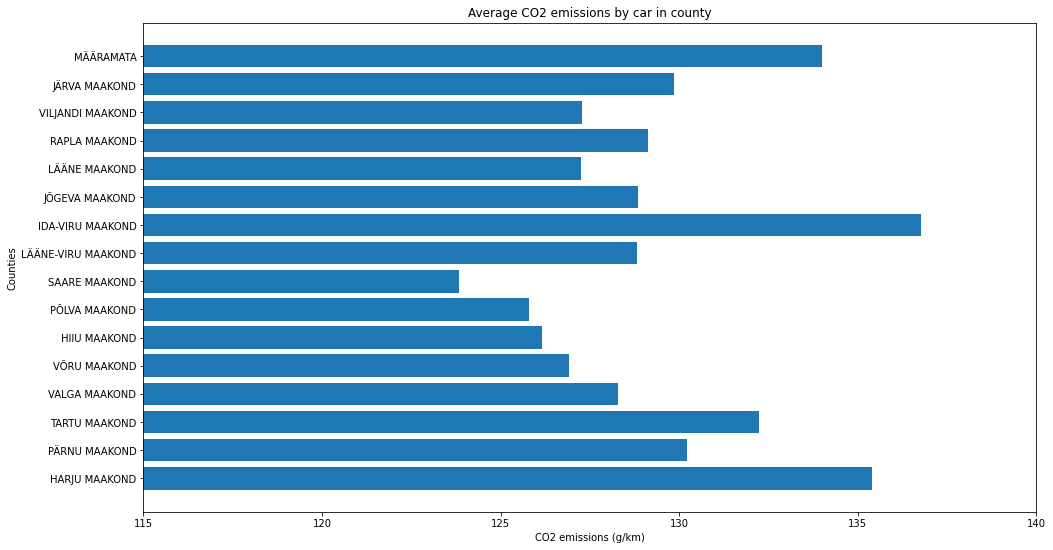

In [20]:
fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(MAAKONNAD, CO2_maakonniti)

ax.set_xlabel('CO2 emissions (g/km)')
ax.set_ylabel('Counties')
ax.set_title('Average CO2 emissions by car in county')

plt.xlim([115,140])

plt.show()

In [21]:
margid={}
for i in range(len(data["Mark"])):
    mark=data["Mark"].iloc[i]
    if str(mark) not in margid:
        margid[str(mark)]=1  

In [22]:
#top 3 enim kasutatud auto mark
for i in range(len(data["Mark"])):
    mark=data["Mark"].iloc[i]
    margid[str(mark)]=margid.get(str(mark))+1
margid=dict(sorted(margid.items(), key=lambda item: item[1]))
print(list(margid.keys())[-1])
print(list(margid.keys())[-2])
print(list(margid.keys())[-3])

VOLKSWAGEN
TOYOTA
AUDI


In [23]:
mudelid_vw={}
mudelid_toyota={}
mudelid_audi={}

for i in range(len(data["Mudel"])):
    mark=data["Mark"].iloc[i]
    mudel=data["Mudel"].iloc[i]
    if str(mark) == "VOLKSWAGEN":
        if str(mudel) not in mudelid_vw:
            mudelid_vw[str(mudel)]=1
        else:
            mudelid_vw[str(mudel)]=mudelid_vw.get(str(mudel))+1
    elif str(mark) == "TOYOTA":
        if str(mudel) not in mudelid_toyota:
            mudelid_toyota[str(mudel)]=1
        else:
            mudelid_toyota[str(mudel)]=mudelid_toyota.get(str(mudel))+1
    elif str(mark) == "AUDI":
        if str(mudel) not in mudelid_audi:
            mudelid_audi[str(mudel)]=1
        else:
            mudelid_audi[str(mudel)]=mudelid_audi.get(str(mudel))+1

In [24]:
mudelid_audi=dict(sorted(mudelid_audi.items(), key=lambda item: item[1]))
mudelid_toyota=dict(sorted(mudelid_toyota.items(), key=lambda item: item[1]))
mudelid_vw=dict(sorted(mudelid_vw.items(), key=lambda item: item[1]))

print("AUDI TOP 3: ")
print(list(mudelid_audi.keys())[-1] + " " + str(list(mudelid_audi.values())[-1]))
print(list(mudelid_audi.keys())[-2] + " " + str(list(mudelid_audi.values())[-2]))
print(list(mudelid_audi.keys())[-3] + " " + str(list(mudelid_audi.values())[-3]))
print(list(mudelid_audi.keys())[-4] + " " + str(list(mudelid_audi.values())[-4]))
print()
print("Volkswagen TOP 3: ")
print(list(mudelid_vw.keys())[-1] + " " + str(list(mudelid_vw.values())[-1]))
print(list(mudelid_vw.keys())[-2] + " " + str(list(mudelid_vw.values())[-2]))
print(list(mudelid_vw.keys())[-3] + " " + str(list(mudelid_vw.values())[-3]))
print()
print("Toyota TOP 3: ")
print(list(mudelid_toyota.keys())[-1] + " " + str(list(mudelid_toyota.values())[-1]))
print(list(mudelid_toyota.keys())[-2] + " " + str(list(mudelid_toyota.values())[-2]))
print(list(mudelid_toyota.keys())[-3] + " " + str(list(mudelid_toyota.values())[-3]))

AUDI TOP 3: 
A6 AVANT 9388
A4 AVANT 7386
A4 4823
A6 4654

Volkswagen TOP 3: 
PASSAT 17186
GOLF 12824
PASSAT VARIANT 11602

Toyota TOP 3: 
AVENSIS 14472
COROLLA 11504
RAV4 11358


In [25]:
mudelid_BMW={}
for i in range(len(data["Mudel"])):
    mark=data["Mark"].iloc[i]
    mudel=data["Mudel"].iloc[i]
    if str(mark) == "BMW":
        if str(mudel) not in mudelid_BMW:
            mudelid_BMW[str(mudel)]=1
        else:
            mudelid_BMW[str(mudel)]=mudelid_BMW.get(str(mudel))+1
mudelid_BMW=dict(sorted(mudelid_BMW.items(), key=lambda item: item[1]))


In [26]:
#Estonian motor sizes
mootori_maht = {}
mootori_mahud = []
mootoreid = []
data["MOOTORI_MAHT"] = data["MOOTORI_MAHT"].fillna(0)
for i in range(len(data["MOOTORI_MAHT"])):
    maht = data["MOOTORI_MAHT"].iloc[i]
    mahtr = round(int(maht)/1000,1)
    if str(mahtr) not in mootori_maht:
        mootori_maht[str(mahtr)] = 1
    else:
        mootori_maht[str(mahtr)]=mootori_maht.get(str(mahtr))+1
mootori_maht=dict(sorted(mootori_maht.items(), key=lambda item: item[1]))

In [27]:
for key, value in mootori_maht.items():
    if int(value) > 25000:
        mootori_mahud.append(key) 
        mootoreid.append(value)

In [28]:
res = {}
mootorcopy = mootoreid.copy()
for key in mootori_mahud:
    for value in mootorcopy:
        res[key] = value
        mootorcopy.remove(value)
        break
res=dict(sorted(res.items(), key=lambda item: item[1]))

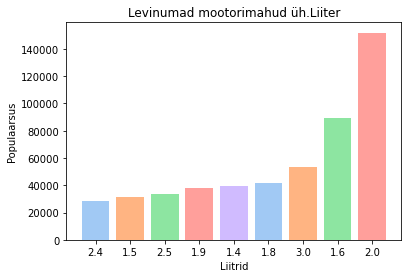

In [29]:
colors = sns.color_palette('pastel')[0:5]
plt.bar(*zip(*res.items()), color=colors)
plt.title('Levinumad mootorimahud üh.Liiter')
plt.ylabel('Populaarsus')
plt.xlabel('Liitrid')
plt.show()

In [30]:
kütused = {}
data["Kütusekombinatsioon"] = data["Kütusekombinatsioon"].fillna("TEADMATA")
for i in range(len(data["Kütusekombinatsioon"])):
    kütus = data["Kütusekombinatsioon"].iloc[i]
    if str(kütus) not in kütused:
        kütused[str(kütus)] = 1
    else:
        kütused[str(kütus)]=kütused.get(str(kütus))+1
kütused=dict(sorted(kütused.items(), key=lambda item: item[1]))
kütused = dict(reversed(list(kütused.items())))

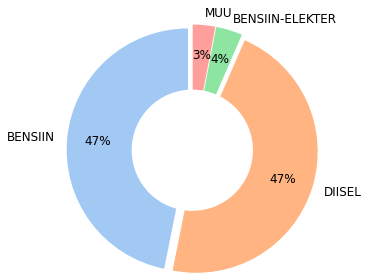

In [31]:
# Data to plot
labels = []
sizes = []

colors = sns.color_palette('pastel')[0:5]
muu_suurus=0
for x, y in kütused.items():
    if str(x)=="DIISEL" or str(x)=="BENSIIN" or str(x)=="BENSIIN-ELEKTER":
        labels.append(x)
        sizes.append(y)
    else:
        muu_suurus+=y

labels.append("MUU")
sizes.append(muu_suurus)

#explsion
explode = (0.05,0.05,0.05,0.05)
 
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.0f%%', startangle=90, pctdistance=0.75, explode = explode, radius=1.4, textprops={'fontsize': 12})
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [32]:
käigukastid = {}
data["KAIGUKASTI_TYYP"] = data["KAIGUKASTI_TYYP"].fillna("TEADMATA")
for i in range(len(data["KAIGUKASTI_TYYP"])):
    käigukast = data["KAIGUKASTI_TYYP"].iloc[i]
    if str(käigukast) not in käigukastid:
        käigukastid[str(käigukast)] = 1
    else:
        käigukastid[str(käigukast)]=käigukastid.get(str(käigukast))+1
käigukastid=dict(sorted(käigukastid.items(), key=lambda item: item[1]))
käigukastid = dict(reversed(list(käigukastid.items())))

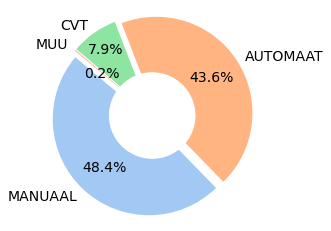

In [33]:
fig =plt.figure(figsize = (4,4))
ax11 = fig.add_subplot(111)
# Data to plot

labels = []
sizes = []

colors = sns.color_palette('pastel')[0:5]
muu_suurus=0
for x, y in käigukastid.items():
    if str(x)=="MANUAAL" or str(x)=="AUTOMAAT" or str(x)=="CVT":
        labels.append(x)
        sizes.append(y)
    else:
        muu_suurus+=y

labels.append("MUU")
sizes.append(muu_suurus)

explode = (0.05,0.05,0.05,0.05)

# Plot
w,l,p = ax11.pie(sizes,  labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=140, pctdistance=1, explode=explode,textprops={'fontsize': 14})

pctdists = [.7, .7, .8, .65]

for t,d in zip(p, pctdists):
    xi,yi = t.get_position()
    ri = np.sqrt(xi**2+yi**2)
    phi = np.arctan2(yi,xi)
    x = d*ri*np.cos(phi)
    y = d*ri*np.sin(phi)
    t.set_position((x,y))
    
centre_circle = plt.Circle((0,0),0.45,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.show()

In [34]:
aastad = {}
for i in range(len(data["ESMANE_REG_KP"])):
    aasta = int(str(data["ESMANE_REG_KP"].iloc[i])[6:10])
    if aasta not in aastad:
        aastad[aasta] = 1
    else:
        aastad[aasta]=aastad.get(aasta)+1

In [35]:
aastad=dict(sorted(aastad.items(), key=lambda item: item[1]))

aasta_vahemikud = ["1900-1989", "1990-1999", "2000-2005", "2006-2010", "2010-2015", "2016-2020", "2021+"]
autode_arv_vahemikus = [0,0,0,0,0,0,0]

for key, value in aastad.items():
    if key > 1899 and key < 1990:
        autode_arv_vahemikus[0] = autode_arv_vahemikus[0] + value
    elif key > 1899 and key < 2000:
        autode_arv_vahemikus[1] = autode_arv_vahemikus[1] + value
    elif key > 1999 and key < 2006:
        autode_arv_vahemikus[2] = autode_arv_vahemikus[2] + value
    elif key > 2005 and key < 2011:
        autode_arv_vahemikus[3] = autode_arv_vahemikus[3] + value
    elif key > 2010 and key < 2016:
        autode_arv_vahemikus[4] = autode_arv_vahemikus[4] + value
    elif key > 2015 and key < 2021:
        autode_arv_vahemikus[5] = autode_arv_vahemikus[5] + value
    else:
        autode_arv_vahemikus[6] = autode_arv_vahemikus[6] + value

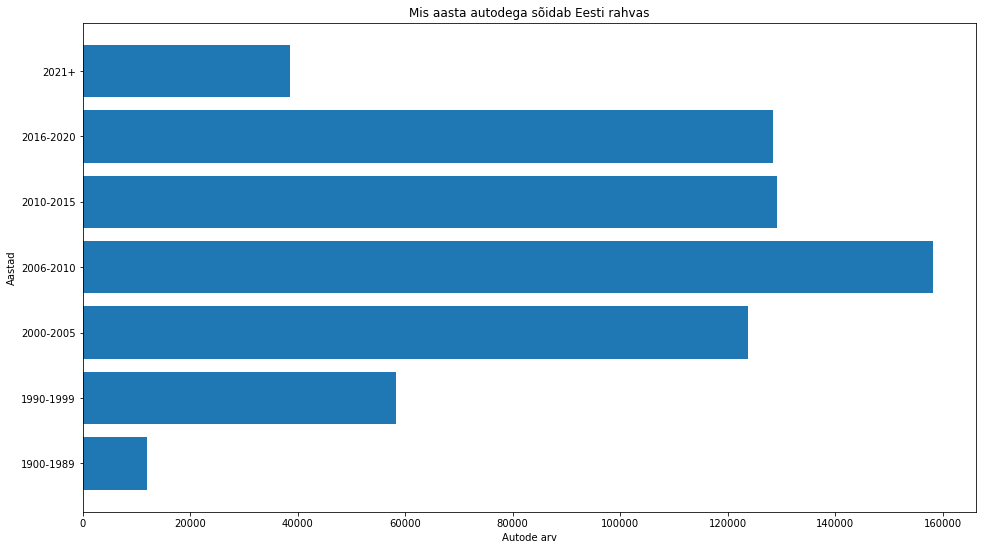

In [36]:
fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(aasta_vahemikud, autode_arv_vahemikus)

ax.set_xlabel('Autode arv')
ax.set_ylabel('Aastad')
ax.set_title('Mis aasta autodega sõidab Eesti rahvas')

plt.show()

In [ ]:
võimsuse_vahemikud = ["0-50", "51-100", "101-150", "151-200", "201-250", "251+"]
autode_arv_võimsuse_vahemikus = [0,0,0,0,0,0]

for i in range(len(data["MOOTORI_VOIMSUS"])):
    võimsus_str = str(data["MOOTORI_VOIMSUS"].iloc[i])
    if ',' in võimsus_str:
        võimsus_str=võimsus_str.replace(",",".")
        data["MOOTORI_VOIMSUS"].iloc[i] = võimsus_str
        
    võimsus = float(võimsus_str)
    if võimsus <= 50:
        autode_arv_võimsuse_vahemikus[0] = autode_arv_võimsuse_vahemikus[0] + 1
    elif võimsus <= 100 and võimsus > 50:
        autode_arv_võimsuse_vahemikus[1] = autode_arv_võimsuse_vahemikus[1] + 1
    elif võimsus <= 150 and võimsus > 100:
        autode_arv_võimsuse_vahemikus[2] = autode_arv_võimsuse_vahemikus[2] + 1
    elif võimsus <= 200 and võimsus > 150:
        autode_arv_võimsuse_vahemikus[3] = autode_arv_võimsuse_vahemikus[3] + 1
    elif võimsus <= 250 and võimsus > 200:
        autode_arv_võimsuse_vahemikus[4] = autode_arv_võimsuse_vahemikus[4] + 1
    else:
        autode_arv_võimsuse_vahemikus[5] = autode_arv_võimsuse_vahemikus[5] + 1
        
data.head(100)

C:\Users\cardo\AppData\Local\Temp\ipykernel_13000\2250848960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["MOOTORI_VOIMSUS"].iloc[i] = võimsus_str


In [ ]:
fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(võimsuse_vahemikud, autode_arv_võimsuse_vahemikus)

ax.set_xlabel('Autode arv')
ax.set_ylabel('Aastad')
ax.set_title('Kui võimsad on Eesti rahva autod')

plt.show()

In [ ]:
#BIG PREDICTION
#tootmisaasta -> keskmise CO2 ->predictime järgnevad aastad CO2 (mis kütus)

In [ ]:
data.head()

In [ ]:
big_predict=data.copy()

In [ ]:
big_predict["AASTA"]=data["ESMANE_REG_KP"].str[-4:]
big_predict=big_predict.drop(["ESMANE_REG_KP","Mark","Mudel","VK/OM MAAKOND", "HEITMENORM"], axis=1)
big_predict=big_predict.dropna()

In [ ]:
big_predict=big_predict.reset_index()
big_predict=big_predict.drop(["index"], axis=1)

In [ ]:
vägaoluline=["BENSIIN-CNG-LPG","DIISEL-LPG","BENSIIN-LNG","ELEKTER-VESINIK","BENSIIN-CNG-ETANOOL","CNG-LPG","LPG","BENSIIN-ETANOOL-LPG","BENSIIN-ETANOOL","BENSIIN-ELEKTER-LPG", "BENSIIN-CNG","DIISEL-ELEKTER", "BENSIIN-LPG", "BENSIIN-ELEKTER"] 
for i in range(len(vägaoluline)):
    big_predict["Kütusekombinatsioon"]=big_predict["Kütusekombinatsioon"].replace([vägaoluline[i]],"MUU")

In [ ]:
#for i in range(len(big_predict["HEITMENORM"])):
#    if "EURO 6" in str(big_predict["HEITMENORM"].iloc[i]):
#        big_predict.loc[i, "HEITMENORM"]="EURO6"
#    elif "EURO6" in str(big_predict["HEITMENORM"].iloc[i]):
#        big_predict.loc[i, "HEITMENORM"]="EURO6"
#   elif "EURO VI" in str(big_predict["HEITMENORM"].iloc[i]):
#        big_predict.loc[i, "HEITMENORM"]="EURO6"
#    elif "EURO 5" in str(big_predict["HEITMENORM"].iloc[i]):
 #       big_predict.loc[i, "HEITMENORM"]="EURO5"
#    elif "EURO V" in str(big_predict["HEITMENORM"].iloc[i]):
#        big_predict.loc[i, "HEITMENORM"]="EURO5"
#    elif "EURO3" in str(big_predict["HEITMENORM"].iloc[i]):
#        big_predict.loc[i, "HEITMENORM"]="EURO3"
#    elif "EURO4" in str(big_predict["HEITMENORM"].iloc[i]):
#        big_predict.loc[i, "HEITMENORM"]="EURO4"
#    elif "EURO1" in str(big_predict["HEITMENORM"].iloc[i]):
#        big_predict.loc[i, "HEITMENORM"]="EURO1"
#    elif "EURO2" in str(big_predict["HEITMENORM"].iloc[i]):
#        big_predict.loc[i, "HEITMENORM"]="EURO2"
#    else:
#        big_predict.loc[i, "HEITMENORM"]="MUU"

In [ ]:
columns = big_predict.columns
big_predict = pd.get_dummies(big_predict, columns=['KAIGUKASTI_TYYP', "Kütusekombinatsioon"])

In [ ]:
#train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#shuffle_data = big_predict.repeat().shuffle(5000).batch(batch_size).prefetch(1)
shuffle_data = big_predict.sample(frac = 1)
shuffle_data=shuffle_data.reset_index()
shuffle_data=shuffle_data.drop(["index"], axis=1)

In [ ]:
shuffle_data.head()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(shuffle_data.iloc[:, shuffle_data.columns!="CO2_NEDC"],shuffle_data["CO2_NEDC"], test_size=0.25, random_state=1)
X_train.shape

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

In [ ]:
#shuffle_data.to_csv("file.csv", encoding="utf-8")

In [ ]:
#column_names = list(train_data.columns.values)
#column_names.remove("CO2_NEDC")
#x=np.array(train_data[column_names])
#y=np.array(train_data["CO2_NEDC"])
linear.fit(X_train,y_train)
y_pred = linear.predict(X_test)
df_preds = pd.DataFrame({"Actual":y_test.squeeze(), "pred":y_pred.squeeze()})
print(df_preds)
print(linear.score(X_train, y_train))
print(linear.score(X_test, y_test))
#print(s.intercept_)
#plt.scatter(X_train, y_train)
#plt.plot(X_train, s, color="red")
#plt.show
print(linear.coef_)

In [ ]:
auto1 = linear.predict([[2000, 96, 1500, 2022, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])
print(auto1)

In [ ]:
autosid = 0
automaate = 0
manuaale = 0
for i in range(len(data["ESMANE_REG_KP"])):
    aasta = int(str(data["ESMANE_REG_KP"].iloc[i])[-4:])
    if aasta >= 2022:
        if str(data["KAIGUKASTI_TYYP"].iloc[i]) == "MANUAAL":
            autosid += 1
            manuaale += 1
        elif str(data["KAIGUKASTI_TYYP"].iloc[i]) == "AUTOMAAT":
            autosid += 1
            automaate += 1
            
print(str((manuaale/autosid)*100) + " %")
print(str((automaate/autosid)*100) + " %")        

In [ ]:
mootori_võimsused = []
for i in range(len(data["MOOTORI_VOIMSUS"])):
    võimsus_str = str(data["MOOTORI_VOIMSUS"].iloc[i])  
    võimsus = float(võimsus_str)
    aasta = int(str(data["ESMANE_REG_KP"].iloc[i])[-4:])
    if aasta >= 2010:
        mootori_võimsused.append(võimsus)

In [ ]:
autod_bensiin = []
autod_diisel = []
aastad = [2025, 2030, 2035, 2040]
auto_võimsus = round(sum(mootori_võimsused)/len(mootori_võimsused))
print(auto_võimsus)
for i in range(len(aastad)):
    autod_diisel.append(linear.predict([[2000, auto_võimsus, 1500, aastad[i], 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])[0])
    autod_bensiin.append(linear.predict([[2000, auto_võimsus, 1500, aastad[i], 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])[0])
    
print(autod_diisel)
print(autod_bensiin)